# Visualizing Adversarial Perturbations

This notebook introduces some examples to visualize perturbations and model activations. See [Adversarial Robustness as a Prior for Learned Representations](https://arxiv.org/abs/1906.00945) for additional visualizations one could do.

## Imports

In [1]:
%matplotlib inline
import random
from pathlib import Path

import matplotlib.pyplot as plt
import torch as tr

random.seed(5643)

## Instantiate

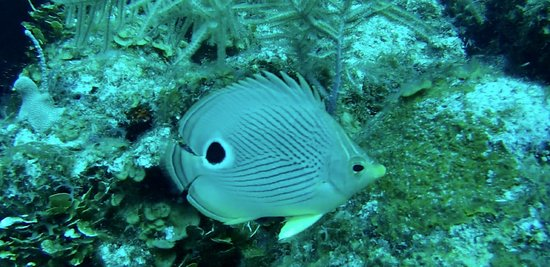

In [2]:
import requests
from PIL import Image
from io import BytesIO


def get_img(url):
    response = requests.get(url)
    if response.status_code == 200:
        return Image.open(BytesIO(response.content))
    else:
        print(response.status_code)
        print("Failed to download image.")


# Example usage:
url = "https://media-cdn.tripadvisor.com/media/photo-s/05/1f/f7/3d/hopkins-underwater-adventures.jpg"
img_pil = get_img(url)
img_pil


In [3]:
# Dictionary of class name to index of label
class_to_id = dict(
    Dog=0, Cat=1, Frog=2, Turtle=3, Bird=4, Monkey=5, Fish=6, Crab=7, Insect=8
)

# Dictionary of index of label to class name
id_to_class = {v: k for k, v in class_to_id.items()}


In [4]:
from rai_experiments.models.pretrained import load_model

model = load_model("mitll_restricted_imagenet_l2_3_0.pt").eval()


## Load and Evaluate Image

Text(0.5, 1.0, 'True: Fish Pred: Fish')

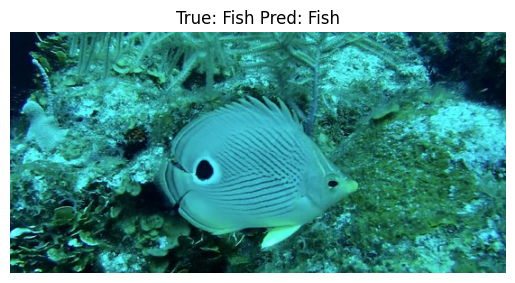

In [5]:
from torchvision.transforms.functional import to_tensor

img, target = to_tensor(img_pil), class_to_id["Fish"]
with tr.no_grad():
    logit = model(img[None])

plt.axis("off")
plt.imshow(img.numpy().transpose(1, 2, 0))
plt.title(f"True: {id_to_class[target]} Pred: {id_to_class[logit.argmax().item()]}")


## Generate Large Perturbation using PGD

/workspaces/responsible-ai-toolbox/src/rai_toolbox/optim/optimizer.py:40: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return x.storage().data_ptr() == y.storage().data_ptr()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'True: Fish Pred: Turtle')

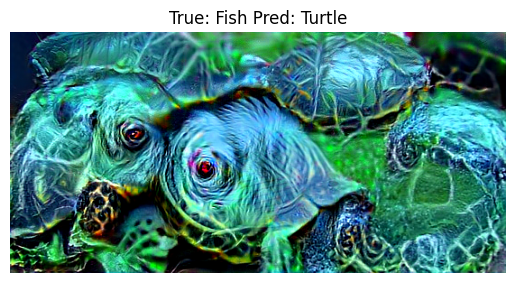

In [6]:
from rai_toolbox.optim import L2ProjectedOptim
from rai_toolbox.perturbations import gradient_ascent

epsilon = 100
steps = 10
lr = 2.5 * epsilon / steps
img_adv, _ = gradient_ascent(
    model=model,
    data=img[None],
    target=tr.tensor([target]),
    optimizer=L2ProjectedOptim,
    steps=steps,
    epsilon=epsilon,
    lr=lr,
)

with tr.no_grad():
    logit_adv = model(img_adv)

plt.axis("off")
plt.imshow(img_adv[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title(f"True: {id_to_class[target]} Pred: {id_to_class[logit_adv.argmax().item()]}")


## Visualize an Activation From the Latent Layer

In [7]:
viz_model = load_model(
    "mitll_restricted_imagenet_l2_3_0.pt", with_latent=True, viz_relu=True
).eval()


In [8]:
# Custom loss to maximize a given component of the representation vector
def feature_vis_loss(rep, targ):
    return rep[:, targ]


Visualization of Activation: 883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'True: Fish Pred: Fish')

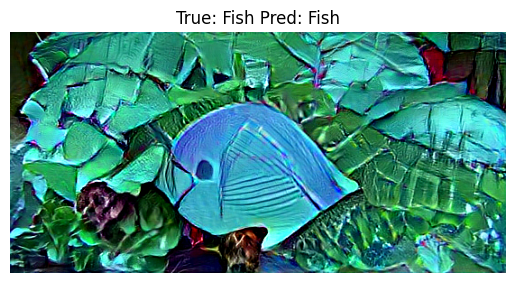

: 

In [9]:
ACTIVATION = random.randint(0, 2047)
print(f"Visualization of Activation: {ACTIVATION}")

epsilon = 100
steps = 10
lr = 2.5 * epsilon / steps
img_adv, _ = gradient_ascent(
    model=viz_model,
    data=img[None],
    target=tr.tensor([ACTIVATION]),
    criterion=feature_vis_loss,
    optimizer=L2ProjectedOptim,
    steps=steps,
    epsilon=epsilon,
    lr=lr,
)

with tr.no_grad():
    logit_adv = model(img_adv)

plt.axis("off")
plt.imshow(img_adv[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title(f"True: {id_to_class[target]} Pred: {id_to_class[logit.argmax().item()]}")
